<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter4/Chapter4_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이동평균과정 모델링하기
2019년부터 500일 동안의 위젯 판매량을 살펴보자.

In [33]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/widget_sales.csv')
df

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108
...,...
495,64.087371
496,63.992081
497,63.029894
498,61.671797


먼저 그래프를 도식화해 보자.

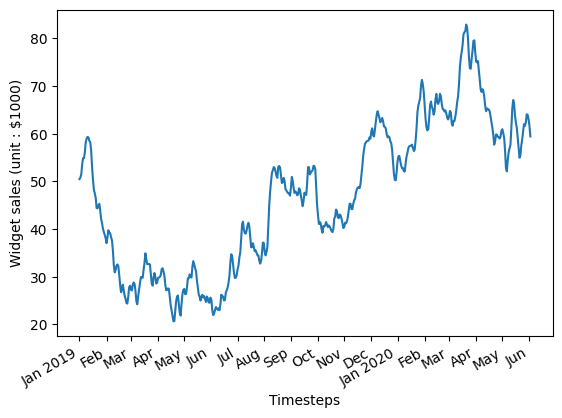

In [34]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

plt.plot(df.iloc[:,0])
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec', 'Jan 2020', 'Feb', 'Mar',
     'Apr', 'May' ,'Jun']
)

plt.xlabel('Timesteps')
plt.ylabel('Widget sales (unit : $1000)')
fig.autofmt_xdate()
plt.show()

것보기에는 정상성이 없는 것으로 보인다.  
ADF 테스트를 통해 확인해보자

In [35]:
from statsmodels.tsa.stattools import adfuller

sales = df['widget_sales'].values
ADF_result = adfuller(sales)
ADF_result

(-1.5121662069359048,
 0.5274845352272605,
 3,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1354.8017397952053)

p-value가 0.05보다 크므로, 시계열이 비정상적이라는 귀무가설을 채택하게 된다.  

시계열을 정상적으로 만들기 위해 변환을 적용해보자

In [36]:
import numpy as np
sales_diff = np.diff(sales, n = 1)
sales_diff

array([ 3.08778437e-01,  6.72264913e-01,  2.06447025e+00,  1.33088006e+00,
        1.20339627e-02,  1.29824354e+00,  2.11848518e+00,  6.94980715e-01,
        3.50263515e-01, -1.15955969e-01, -7.20037664e-01, -3.16219814e-01,
       -1.83523313e+00, -3.37428137e+00, -2.68869765e+00, -2.03636525e+00,
       -7.65986934e-01, -9.29050812e-01, -2.13525117e+00, -7.78317849e-02,
        6.69616481e-01,  3.04024165e-01, -1.43170569e+00, -1.80639763e+00,
       -8.06446318e-01, -1.21447806e+00, -6.26919424e-01, -6.07808547e-01,
       -7.19559165e-01, -1.04442259e+00,  1.22323411e+00,  1.47304116e+00,
       -5.14174976e-01, -1.33444091e-01, -7.97866508e-01, -6.43132216e-01,
       -2.13794598e+00, -3.02923008e+00, -1.58640725e+00,  5.17185878e-01,
        8.95046574e-01,  2.60123145e-01, -3.53776665e-01, -1.78420980e+00,
       -2.14084511e+00, -1.55205516e+00,  4.26594070e-01,  1.15683666e+00,
       -1.13664703e+00, -1.15956668e+00, -6.22318755e-01, -9.26270862e-01,
       -1.13078196e-01,  

In [37]:
print(sales.shape)
print(sales_diff.shape)

(500,)
(499,)


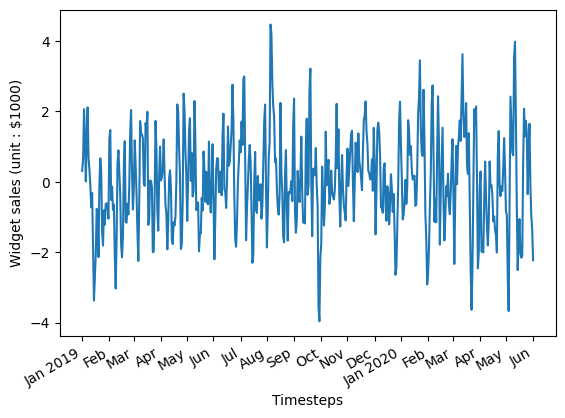

In [38]:

fig,ax = plt.subplots()

plt.plot(sales_diff)
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec', 'Jan 2020', 'Feb', 'Mar',
     'Apr', 'May' ,'Jun']
)

plt.xlabel('Timesteps')
plt.ylabel('Widget sales (unit : $1000)')
fig.autofmt_xdate()
plt.show()

1차분이후 전체기간 동안 값이 0근처에 고정되어 있으므로 수열의 추세 구성 요소를 성공적으로 제거했음을 알 수 있다.  
ADF테스트로 확인해보자

In [39]:
ADF_result = adfuller(sales_diff)
ADF_result

(-10.576657780341959,
 7.076922818587193e-19,
 2,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1350.640860630276)

예상대로 p-value가 0.05보다 낮으므로 정상성이 있다고 볼 수 있다.  
이제 acf함수를 도식화해보자

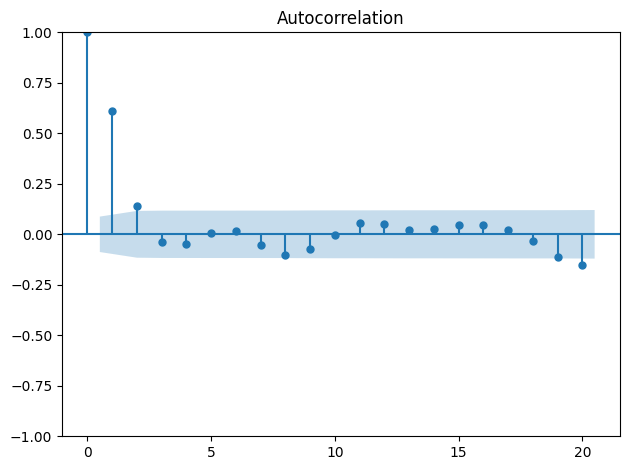

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales_diff, lags = 20)
plt.tight_layout()

지연 2까지는 유의한 계수가 있음을 알 수 있다.  
그러므로 MA(2) 모델을 사용하여 정상적 시계열을 예측할 수 있다.

# 이동평균과정 예측하기  
데이터의 90%를 훈련 집합에 할당하고, 나머지 10%를 테스트 집합에 할당하여 50번에 해당하는 미래의 시간 단계에 대한 예측을 진행해보자.

In [93]:
df_diff = pd.DataFrame({'widget_sales_diff' : sales_diff})

train = df_diff[:int(len(df_diff)*(0.9))]
test = df_diff[int(len(df_diff)*(0.9)):]
print(len(train))
print(len(test))

449
50


## 롤링 피팅
첫 번쨰 반복에서는 첫 번쨰 449개 시간 단계에 대해 훈련한 후, 이후 미래인 450번째와 451번쨰 시간 단계를 예측한다.  
그런 다음 두 번째 반복에서는 첫 번째 451 시간 단계에 대해 훈련한 후 452번째와 453번째 시간단계를 예측한다.  
마지막으로 498번째와 499번째 시간 단계를 예측할 때까지 이 과정을 반복한다.

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df : pd.DataFrame, train_len : int, horizon : int, window : int, method : str) -> list:

  total_len = train_len + horizon

  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i].values)
      pred_mean.extend(mean for _ in range(window))

    return pred_mean
  elif method == 'last':
    pred_last_value = []
    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))
    return pred_last_value
  elif method == 'MA':
    pred_MA = []

    for i in range(train_len, total_len ,window):
      model = SARIMAX(df[:i], order = (0,0,2))
      res = model.fit(disp = False)
      predictions = res.get_prediction(0, i+ window -1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_MA.extend(oos_pred)
    return pred_MA


In [89]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
pred_df

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994
454,-1.118891,0.032183,-0.096564,0.115810
455,-0.979693,0.028764,-1.118891,-0.795666
456,-1.369431,0.028764,-1.118891,-0.191286
457,-1.517477,0.023498,-1.369431,-0.922824
458,-2.006735,0.023498,-1.369431,-0.254060


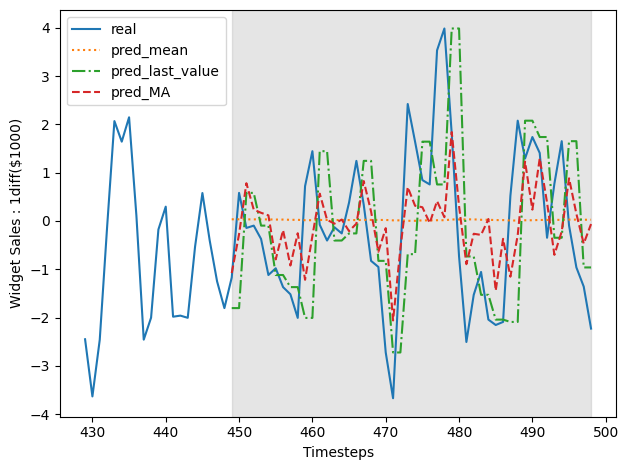

In [106]:
fig,ax = plt.subplots()

plt.plot(df_diff[-(len(pred_df)+20):], label = 'real', linestyle = 'solid')
plt.plot(pred_df[-(len(test)):].iloc[:,-3], label = 'pred_mean', linestyle = 'dotted')
plt.plot(pred_df[-(len(test)):].iloc[:,-2], label = 'pred_last_value', linestyle = '-.')
plt.plot(pred_df[-(len(test)):].iloc[:,-1], label = 'pred_MA', linestyle = 'dashed')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Widget Sales : 1diff($1000)')
ax.axvspan(449,498, color = '#808080', alpha = 0.2)
plt.tight_layout()
plt.show()

이제 mean_squared_error를 통해 성능을 비교해보자

In [110]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test, pred_df['pred_mean'])
mse_last_value = mean_squared_error(test, pred_df['pred_last_value'])
mse_MA = mean_squared_error(test, pred_df['pred_MA'])

print(mse_mean, mse_last_value, mse_MA)

2.5606299456880537 3.2494260812249225 1.948171449776926


MA(2)모델의 MSE가 가장 낮음을 알 수 있다. (즉, 성능이 제일 좋음)  


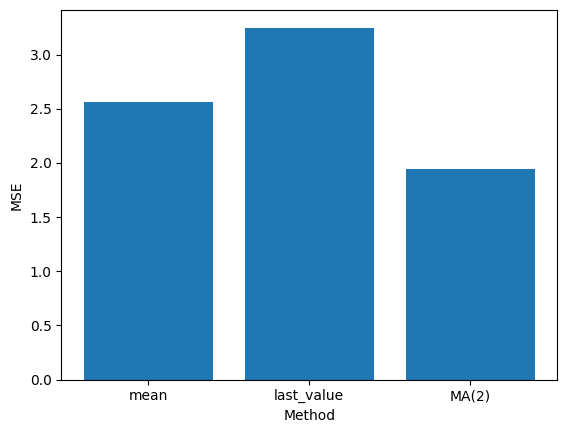

In [114]:
mse = [mse_mean, mse_last_value, mse_MA]
plt.bar(['mean','last_value','MA(2)'],mse)
plt.xlabel('Method')
plt.ylabel('MSE')

plt.show()

# 역변환

In [115]:
df

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108
...,...
495,64.087371
496,63.992081
497,63.029894
498,61.671797


In [147]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[449] + pred_df['pred_MA'].cumsum()

<ipython-input-147-dacb33c1e393>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[449] + pred_df['pred_MA'].cumsum()
<ipython-input-147-dacb33c1e393>:2: SettingWithCopyWarning: 
A value

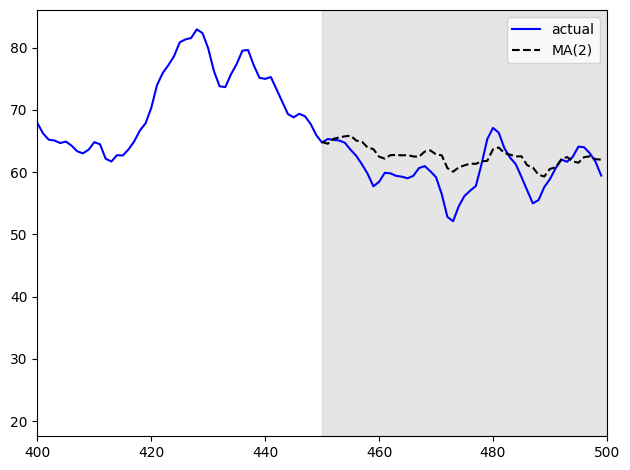

In [148]:
fig, ax = plt.subplots()
ax.plot(df['widget_sales'], 'b-', label = 'actual')
ax.plot(df['pred_widget_sales'], 'k--', label = 'MA(2)')
ax.legend()

ax.axvspan(450, 500, color = '#808080',alpha = 0.2)
plt.xlim(400,500)
plt.tight_layout()

마지막으로 원본 데이터 집합에 대한 MSE를 구해보자

In [149]:
from sklearn.metrics import mean_absolute_error

mse_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mse_MA_undiff)

2.7656641101118606
